In [1]:
#Handle Imports
import cv2
import numpy as np
import math
import pylab as pl
import matplotlib.pyplot as plt
import random

from os import listdir
from os.path import isfile, join
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model

from __future__ import print_function
from __future__ import division
np.random.seed(1337)  # for reproducibility

%matplotlib inline

Using TensorFlow backend.


In [2]:
import os
for filename in os.listdir("Positives/"):
        if filename.endswith('.jpg'):
            newpath = 'Positives/' + filename 
            img = cv2.imread(newpath ,0)
            rows, cols = img.shape
        for x in range(4):
            if filename.endswith('.jpg'):
                p = os.path.join(os.path.join('Positives/', 'data'), filename  + '_' + str(x * 90) + '.jpg')
                cv2.imwrite(p,img)
                
                #Rotate image
                img = np.rot90(img)

In [3]:
windowsize = 32

In [4]:
'''
This module will handle pre-processing such as labeling inages as positives and negatives.  If you would like to use
the data from the folders just download them and change the paths.
'''

#Read all images from folder.
pospath = "Positives/data/"
positives = [f for f in listdir(pospath) if isfile(join(pospath, f))]

negpath = "Negatives/"
negatives = [f for f in listdir(negpath) if isfile(join(negpath, f))]

#create array to hold all data
numImages = len(positives) + len(negatives)
data = np.zeros((numImages, windowsize**2 + 1))

#choose 80/20 ratio for splitting data because of Pareto principle
split = math.floor(numImages * 0.8)

#load Positives
for i in range(len(positives)):
    path = pospath + positives[i]
    particle = cv2.imread(path)
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    ##Added Collin 4/24
    #resize Image to fit window
    particle = cv2.resize(particle, (windowsize, windowsize),interpolation = cv2.INTER_AREA) 
    
    particle = particle.flatten()
    particle = np.insert(particle, windowsize**2, 1)
    data[i] = particle
    
#load Negatives
for i in range(len(negatives)):
    path = negpath + negatives[i]
    particle = cv2.imread(path)
    particle = cv2.cvtColor(particle, cv2.COLOR_BGR2GRAY)
    
    ##Added Collin 4/24
    #resize Image to fit window
    particle = cv2.resize(particle, (windowsize, windowsize),interpolation = cv2.INTER_AREA) 
    
    particle = particle.flatten()
    particle = np.insert(particle, windowsize**2, 0)
    data[len(positives) + i] = particle

#shuffle examples
np.random.shuffle(data)
data = data.astype('float32')
#split data into training and testing sets
X_train = data[int(0):int(split), int(0):int(windowsize**2)]
y_train = data[int(0):int(split), int(windowsize**2)]
X_test = data[int(split):,int(0):int(windowsize**2)]
y_test = data[int(split):, int(windowsize**2)]

#reshape images to be routed to classifier
X_train = np.reshape(X_train, (int(split), windowsize, windowsize))
X_test = np.reshape(X_test, (numImages - int(split), windowsize, windowsize))

In [5]:
'''This module will set up hyper parameters and  normalize the data'''

batch_size = 10
nb_classes = 2
nb_epoch = 60

# input image dimensions
img_rows, img_cols = windowsize, windowsize
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train.astype('int'), nb_classes)
Y_test = np_utils.to_categorical(y_test.astype('int'), nb_classes) 

X_train shape: (742, 32, 32, 1)
742 train samples
186 test samples


In [6]:
if os.path.exists('my_model.h5'):
    model = load_model('my_model.h5')
else:
    #Make model
    '''Model creation and fitting'''

    model = Sequential()

    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                            border_mode='valid',
                            input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              verbose=1, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])



/home/collin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="valid", input_shape=(32, 32, 1...)`
/home/collin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
/home/collin/anaconda2/lib/python2.7/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 742 samples, validate on 186 samples
Epoch 1/60
742/742 [==============================] - 3s - loss: 0.6964 - acc: 0.5323 - val_loss: 0.6750 - val_acc: 0.5645
Epoch 2/60
742/742 [==============================] - 2s - loss: 0.6643 - acc: 0.5916 - val_loss: 0.5937 - val_acc: 0.6774
Epoch 3/60
742/742 [==============================] - 2s - loss: 0.5981 - acc: 0.6685 - val_loss: 0.4842 - val_acc: 0.9247
Epoch 4/60
742/742 [==============================] - 2s - loss: 0.4506 - acc: 0.8046 - val_loss: 0.5846 - val_acc: 0.6344
Epoch 5/60
742/742 [==============================] - 2s - loss: 0.3549 - acc: 0.8693 - val_loss: 0.2731 - val_acc: 0.9247
Epoch 6/60
742/742 [==============================] - 2s - loss: 0.2843 - acc: 0.9016 - val_loss: 0.2264 - val_acc: 0.8925
Epoch 7/60
742/742 [==============================] - 2s - loss: 0.2617 - acc: 0.9137 - val_loss: 0.3073 - val_acc: 0.8602
Epoch 8/60
742/742 [==============================] - 2s - loss: 0.1975 - acc: 0.9353 - val_l

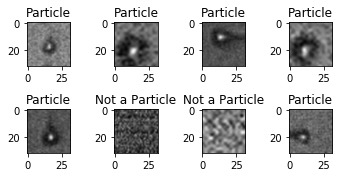

In [7]:
'''Visualize Predictions'''

fig = plt.figure()
fig.subplots_adjust(hspace=1)

predictions = model.predict_classes(X_test, batch_size=32, verbose=0)

displays = 8

for i in range(displays):
    x = random.sample(xrange(1,len(X_test)), displays)
    img = np.squeeze(X_test[x[i]])
    ax = plt.subplot(341 + i)
    if(predictions[x[i]] == 1):
        ax.set_title("Particle")
    else:
        ax.set_title("Not a Particle")
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')

plt.show()

In [8]:
class classifier:

    def __int__(self, image):
        self.image = image


    def c(self):
        percent = 10
        prob = random.randrange(0,100)
        if prob > percent:
            return False
        else:
            return True

In [9]:
import time
import random
import pprint
import numpy as np
import sys
import cv2
import os



class SlidingWindow(object):

    def __int__(self, blc, image, classifier, shift_r, shift_d, boundingboxes):

        self.blc = blc
        self.image = image
        self.classifier = classifier
        self.shift_r = shift_r
        self.shift_d = shift_d
        self.boundingboxes = boundingboxes

        """"
        BLC : Bottom Left Corner : This indicates the start point of the sliding window and takes in a value such as 32
        Image : This is the image that will be passed as a numpy array
        Classifier : This is the reference from the CNN handling the identification
        ShiftR : Shift Right : This is how many pixels the image will shift to the right
        ShiftD : Shift Down : This is how many pixels the image will shift down
        """


    def move_slider(self,verbose=0):

        count_x = 0  # number to increase each iteration of while
        count_y = 0
        shape_of_array = np.shape(self.image)  # the dimensions of the numpy Image array

        max_x = shape_of_array[1]  # the dimension along the x axis
        print( max_x)
        max_y = shape_of_array[0]  # the dimension along the y axis
        print( max_y)

        slice_obj = (slice(0, self.blc-1, 1), slice(0, self.blc-1, 1))  # sets the slice of 0 to the BLC of each axis
        sub_image = self.image[slice_obj]  # gets the pixel values from the 0 index to the max index of the passed BLC

        blc_x = self.blc
        blc_y = self.blc
        
        count_yes = 1
        dirname = 'Observed'
        

        while blc_y < max_y:

            # first run through starts at 0,0 and has a BLC of what was passed in i.e. 32x32
            # once that has run through this while loop lowers the sub_image(0, ShiftD)

            start_y = count_y * self.shift_d  # where the index of the array should start
            end_y = self.blc - 1 + (count_y * self.shift_d)  # where the index of the array for y should end

            new_y_range = (slice(start_y, end_y, 1))
            # new_y_range is the slice of the y axis from the start of the count to the BLC provided


            while blc_x < max_x:

                # as stated the first run through the top left sets to 0,0
                # in this case the window will slide to the right a number of pixels equal to shift_r

                # first iteration: (0, 0) through (31, 31)
                # second iteration: (shiftR, 0) through (31+ShiftR, 32)

                start_x = count_x * self.shift_r  # where the index of the array should start
                end_x = self.blc - 1 + (count_x * self.shift_r)  # where the index of the array for y should end

                new_x_range = (slice(start_x, end_x, 1))
                # new_x_dim is the slice of the y axis from the start of the count to the BLC provided

                slice_obj = (new_x_range, new_y_range)

                sub_image = self.image[slice_obj]

                shape_of_sub_array = np.shape(sub_image)
                if(sub_image.shape == (windowsize, windowsize) ):
                    myparticle = sub_image.flatten()
                    myparticle = myparticle.reshape(1,  img_rows, img_cols, 1)
                    myparticle = myparticle.astype('float32')
                    myparticle /= 255
                    
                    
                    
                    mypredictions = model.predict_classes(myparticle, batch_size=1, verbose=0)
                    if(mypredictions[0] == 1):
                        if verbose == 1:
                            print('found one at X: ' ,start_x, 'and Y: ' , start_y)
                        
                        ## added 3/24 @ 4:45 pm - Matt
                        file_name = '{}_jar.jpg'.format(count_yes)  # sets the name of each image to a new name inline with count_yes
                        cv2.imwrite(os.path.join(dirname, file_name), sub_image)  # writes the image to a new image with name file_name
                        count_yes += 1  # increments the count change the file name
                        
                        ## added April 23rd @ 1:53 - Collin
                        self.boundingboxes.append([start_x,start_y,end_x,end_y])                       
                    
                        
                clone = self.image.copy()
                
                #if verbose == 1:
                    #cv2.imshow("Window", clone)
                    #cv2.waitKey(1)

                count_x += 1
                blc_x = self.blc + (count_x * self.shift_r)

            count_y += 1
            if blc_y < max_y:
                blc_y = self.blc + (count_y * self.shift_d)

            if blc_x >= max_x:
                blc_x = self.blc
                count_x = 0
                
        ## added April 23rd @ 1:53 - Collin
        self.boundingboxes = np.array(self.boundingboxes)

In [10]:
def non_maximum_supression_slow(boxes, overlapThresh):
# if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
 
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    
        # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        # loop over all indexes in the indexes list
        for pos in xrange(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

In [11]:
def pyramid(above,aboveRatio, below, belowRatio, image, sliding_window):
        stack = None
        
        #Above
        for x in range(1, above+1):
                           
            #Resize Image
            slicefrac = 1+x*belowRatio
            im = cv2.resize(img,None,fx=1/slicefrac, fy=1/slicefrac, interpolation = cv2.INTER_CUBIC)
            sliding_window.image=im
            
            #Run Sliding Window
            sliding_window.boundingboxes = []
            sliding_window.move_slider(verbose=1)
            if stack is None:
                #print ("Stack is empty.  But Bounding Boxes type is: ", type(sliding_window.boundingboxes))
                stack = sliding_window.boundingboxes
            else:
                #print ("Stack is not empty.  Stack shape is: ", stack.shape)
                if sliding_window.boundingboxes.shape[0] != 0:
                    #print ("Bounding Boxes shape is: ", sliding_window.boundingboxes.shape[0])
                    sliding_window.boundingboxes = sliding_window.boundingboxes
                    stack = np.concatenate((stack, (sliding_window.boundingboxes*(slicefrac))), axis=0)
                    
            
            #print("Above image size: ", im.shape)
            
        #Middle
        #Set Image
        sliding_window.image=image
        
        #Run Sliding Window
        sliding_window.boundingboxes = []
        sliding_window.move_slider(verbose=1)
        
        if stack is None:
                #print ("Stack is empty.  But Bounding Boxes type is: ", type(sliding_window.boundingboxes))
                stack = sliding_window.boundingboxes
        else:
            #print ("Stack is not empty.  Stack shape is: ", stack.shape)
            if sliding_window.boundingboxes.shape[0] != 0:
                #print ("Bounding Boxes shape is: ", sliding_window.boundingboxes.shape[0])
                sliding_window.boundingboxes = sliding_window.boundingboxes
                stack = np.concatenate((stack, sliding_window.boundingboxes), axis=0)
        
        #Below
        for x in range(1, below+1):
            if stack is None:
                continue
                #print ("Stack is empty")
                
            #Resize Image    
            slicefrac = 1+x*belowRatio
            im = cv2.resize(img,None,fx=slicefrac, fy=slicefrac, interpolation = cv2.INTER_CUBIC)
            sliding_window.image=im
            
            #Run Sliding Window
            sliding_window.boundingboxes = []
            sliding_window.move_slider(verbose=1)
            if stack is None:
                stack = sliding_window.boundingboxes
            else:
                if sliding_window.boundingboxes.shape[0] != 0:
                    stack = np.concatenate((stack, (sliding_window.boundingboxes*(1/slicefrac))), axis=0)
            #print("Below image size: ", im.shape)
        
        return stack

In [12]:
s_w = SlidingWindow()
blc = windowsize + 1
s_w.blc=blc
shift_r = 16
shift_d = 16
s_w.shift_r=shift_r
s_w.shift_d=shift_d

im = cv2.imread('pic2.jpg', 0)

py = pyramid(2, .1, 2, .5, im, s_w)

21
21
16
16
1280
960
found one at X:  368 and Y:  0
found one at X:  368 and Y:  112
found one at X:  384 and Y:  112
found one at X:  400 and Y:  112
found one at X:  368 and Y:  192
found one at X:  368 and Y:  208
found one at X:  384 and Y:  224
found one at X:  384 and Y:  240
found one at X:  352 and Y:  272
found one at X:  352 and Y:  288
found one at X:  368 and Y:  288


ValueError: all the input arrays must have same number of dimensions

In [ ]:
py = py.astype(int)
pre_suppress = np.copy(im)
for y in py:
    cv2.rectangle(pre_suppress, (y[1], y[0]), (y[3], y[2]), (0, 255, 0), 1)
plt.figure(figsize=(26,14))
plt.imshow(pre_suppress,cmap = 'gray', interpolation = 'bicubic')
pick = non_maximum_supression_slow(py, 0.1)
post_suppress = np.copy(im)
for y in pick:
    cv2.rectangle(post_suppress, (y[1], y[0]), (y[3], y[2]), (0, 255, 0), 1)
plt.figure(figsize=(26,14))
plt.imshow(post_suppress,cmap = 'gray', interpolation = 'bicubic')

In [ ]:
dirname = "Detected Particles"
for x in range(pick.shape[0]):
    file_name = '{}_{}.jpg'.format(pick[x,1], pick[x,2])
    img = cv2.resize(im[pick[x,0]:pick[x,2], pick[x,1]:pick[x,3]], (32, 32)) 
    cv2.imwrite(os.path.join(dirname, file_name), img)  # writes the image to a new image with name file_name